First import relevant Python modules below:

In [1]:
import pandas_datareader.data as web
import datetime
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Create start and end dates for data being imported

In [2]:
start = datetime.datetime(2020, 12, 1)
end = date.today()

First we need to import data from an API. I chose yahoo finance as mine.
Enter tickers in 'symbols' to build a optimized portfolio with:

In [3]:
symbols = ['TSLA', 'RBLX', 'GME', 'AMC', 'RTX']
daily_stock_data = web.DataReader(symbols, 'yahoo', start, end)

# Once the line below is uncommented the optimal volatility line stops showing up "(plotted by plt.plot(volatility_opt, returns, '--')")
#daily_stock_data = web.get_data_yahoo(symbols,start,end,interval='w')

print(daily_stock_data.head(-5).round(2))

Attributes Adj Close                                Close                 \
Symbols         TSLA   RBLX     GME    AMC    RTX    TSLA   RBLX     GME   
Date                                                                       
2020-12-01    584.76    NaN   15.80   4.15  70.37  584.76    NaN   15.80   
2020-12-02    568.82    NaN   16.58   4.32  71.07  568.82    NaN   16.58   
2020-12-03    593.38    NaN   16.12   3.63  72.41  593.38    NaN   16.12   
2020-12-04    599.04    NaN   16.90   3.51  73.02  599.04    NaN   16.90   
2020-12-07    641.76    NaN   16.35   3.56  72.16  641.76    NaN   16.35   
...              ...    ...     ...    ...    ...     ...    ...     ...   
2021-05-17    576.83  76.93  180.60  13.95  86.05  576.83  76.93  180.60   
2021-05-18    577.87  74.99  180.67  14.03  84.87  577.87  74.99  180.67   
2021-05-19    563.46  75.22  168.83  12.64  84.70  563.46  75.22  168.83   
2021-05-20    586.78  76.33  170.49  12.55  85.23  586.78  76.33  170.49   
2021-05-21  

Now we need to get the (daily) returns for each stock. To do this we take all the data from the column with closing price data and we divide each closing price in the column by the closing price immediately preceding it.

In [4]:
daily_returns = daily_stock_data['Close']/daily_stock_data['Close'].shift(1)
print(daily_returns.round(2))

Symbols     TSLA  RBLX   GME   AMC   RTX
Date                                    
2020-12-01   NaN   NaN   NaN   NaN   NaN
2020-12-02  0.97   NaN  1.05  1.04  1.01
2020-12-03  1.04   NaN  0.97  0.84  1.02
2020-12-04  1.01   NaN  1.05  0.97  1.01
2020-12-07  1.07   NaN  0.97  1.01  0.99
...          ...   ...   ...   ...   ...
2021-05-24  1.04  1.08  1.02  1.13  1.01
2021-05-25  1.00  1.00  1.16  1.20  1.00
2021-05-26  1.02  1.00  1.16  1.19  1.00
2021-05-27  1.02  1.09  1.05  1.36  1.02
2021-05-28  0.99  0.96  0.87  0.98  1.00

[124 rows x 5 columns]


Using the daily_returns we can calculate the log return to give us a better idea of the return of each stock (since some stocks have higher/lower per share prices, we need log return to better analyze the stock.

In [5]:
log_returns = np.log(daily_returns)
print(log_returns)

Symbols         TSLA      RBLX       GME       AMC       RTX
Date                                                        
2020-12-01       NaN       NaN       NaN       NaN       NaN
2020-12-02 -0.027637       NaN  0.048187  0.040147  0.009918
2020-12-03  0.042271       NaN -0.028136 -0.174023  0.018592
2020-12-04  0.009493       NaN  0.047253 -0.033617  0.008424
2020-12-07  0.068886       NaN -0.033086  0.014144 -0.011841
...              ...       ...       ...       ...       ...
2021-05-24  0.043062  0.078419  0.018050  0.124384  0.007778
2021-05-25 -0.002890  0.001008  0.151377  0.181956 -0.002547
2021-05-26  0.023599  0.004357  0.146860  0.175596  0.002778
2021-05-27  0.018753  0.082962  0.046597  0.304413  0.024100
2021-05-28 -0.008965 -0.038700 -0.135169 -0.015198  0.001128

[124 rows x 5 columns]


# The Sharpe Ratio

the Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment.

# Return vs Volatility Chart

Generate almost all portfolios and plot them on a graph.

In [6]:
# Come back later and replace '4' with 'len(symbols)'. Just remember you'll have to change 'bounds' and 'constraints' too.

num_portfolios = 30000
weight = np.zeros((num_portfolios, len(symbols)))
expectedreturn = np.zeros(num_portfolios)
expectedvolatility = np.zeros(num_portfolios)
sharperatio = np.zeros(num_portfolios)

mean_log_return = log_returns.mean()
Sigma = log_returns.cov()
for k in range(num_portfolios):
    # Generate random weight vector
    w = np.array(np.random.random(len(symbols)))
    w = w / np.sum(w)
    weight[k,:] = w
    # Expected log return
    expectedreturn[k] = np.sum(mean_log_return * w)
    # Expected volatility
    expectedvolatility[k] = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    # Sharpe Ratio
    sharperatio[k] = expectedreturn[k]/expectedvolatility[k]
    
maxIndex = sharperatio.argmax()
print(mean_log_return.round(5))

Symbols
TSLA    0.00054
RBLX    0.00535
GME     0.02149
AMC     0.01496
RTX     0.00178
dtype: float64


In [7]:
weight[maxIndex,:]

array([0.03011877, 0.11539516, 0.08732456, 0.00373039, 0.76343111])

Now lets plot some graphs. First, create a figure

# Efficient Markowitz Frontier
Now lets get the optimal portfolios using the vectors we calculated earlier ('expectedreturn', 'expectedvolatility', 'sharperatio'

In [8]:
def negativeSR(w):
    w = np.array(w)
    R = np.sum(mean_log_return*w)
    V = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    SR = R/V
    return -1*SR

def checkSumToOne(w):
    return np.sum(w)-1

#w0 = [0.20,0.20,0.20,0.20,0.20]
w0 = [1/len(symbols)] * len(symbols)
#bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
bounds = ((0,1),) * len(symbols)
constraints = ({'type':'eq', 'fun':checkSumToOne})
w_opt = minimize(negativeSR,w0,method='SLSQP',bounds=bounds,constraints=constraints)
w_opt

     fun: -0.18341616058781693
     jac: array([ 7.73897674e-02,  7.88675621e-04, -1.09641440e-03, -8.11383128e-04,
       -4.46084887e-05])
 message: 'Optimization terminated successfully'
    nfev: 75
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.        , 0.13161914, 0.0516598 , 0.01398688, 0.80273419])

In [9]:
symbols

['TSLA', 'RBLX', 'GME', 'AMC', 'RTX']

So, 'x' tells us our optimal weights and 'nit' tells us the number of iterations it took to get this answer. Notice that our answer for 'x' is very similar to the output for 'weight[maxIndex,:]'

Now we're going to define a function to find us the portfolios with the lowest volatilities that still provide decent returns

In [10]:
returns = np.linspace(0,0.01,50)
volatility_opt = []
def minimizeMyVolatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    return V
def getReturn(w):
    w = np.array(w)
    R = np.sum(mean_log_return*w)
    return R
for R in returns:
    # Find best volatilities
    constraints = ({'type':'eq', 'fun':checkSumToOne}, {'type':'eq', 'fun': lambda w: getReturn(w) - R})
    opt = minimize(minimizeMyVolatility,w0,method='SLSQP',bounds=bounds,constraints=constraints)
    # Save my optimal volatility
    volatility_opt.append(opt['fun'])

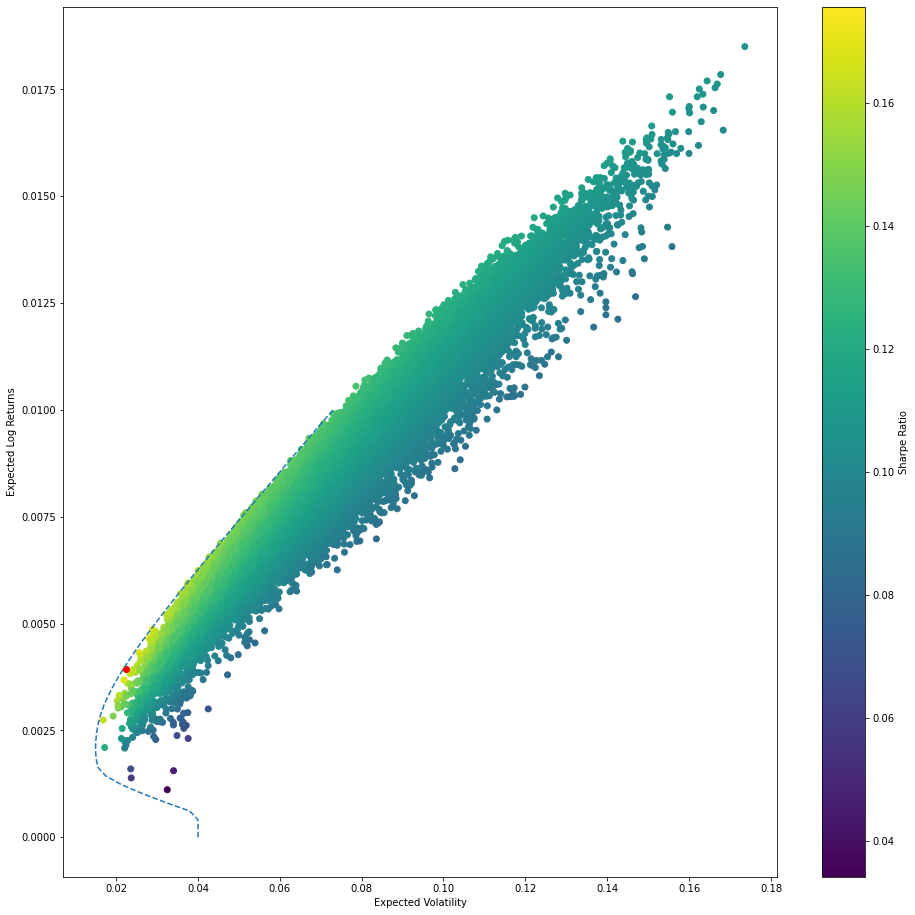

In [11]:
plt.figure(figsize=(16, 16))
plt.scatter(expectedvolatility, expectedreturn, c=sharperatio)  # 'c=sharperatio' passes in the color map ratios indexed by 'sharperatio'
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(expectedvolatility[maxIndex], expectedreturn[maxIndex], c='red')
plt.plot(volatility_opt, returns, '--')
plt.show()